In [1]:
import numpy as np
import torch
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.spatial import KDTree
# knn based permutation as described in K-Nearest-Neighbor Local Sampling Based
# Conditional Independence Testing Shuai et al
# https://openreview.net/forum?id=luyXPdkNSN&referrer=%5Bthe%20profile%20of%20Christina%20Dan%20Wang%5D(%2Fprofile%3Fid%3D~Christina_Dan_Wang1)

In [2]:
def sample_q_knn(x, y, z):
    """
    sample p(x,y)p(y|z) using k-th nearest neighbour
    """
    # 1-NN based sampling from p(y|z) with DV representation in classifier based KL estimator
    # x, y, z - 2dim arrays
    # with a even number of observations
    if x.shape[0] % 2:
        x = x[:-1]
        y = y[:-1]
        z = z[:-1]
    if len(x.shape) == 1:
        x=x.reshape(-1, 1)
    if len(y.shape) == 1:
        y=y.reshape(-1, 1)
    if len(z.shape) == 1:
        z=z.reshape(-1, 1)
        
    # shuffle samples
    data_perm = np.random.permutation(x.shape[0])
    x = x[data_perm]
    y = y[data_perm]
    z = z[data_perm]
    # split into v2 and v1
    v1_ix = np.array([True] * (x.shape[0] // 2) + [False] * (x.shape[0] // 2))
    v2_ix = ~v1_ix



    # make v1
    x1 = x[v1_ix].copy()
    y1 = y[v1_ix].copy()
    z1 = z[v1_ix].copy()
    v1 = np.column_stack([x1, y1, z1])
    # make v2
    x2 = x[v2_ix].copy()
    y2 = y[v2_ix].copy()
    z2 = z[v2_ix].copy()
    v2 = np.column_stack([x2, y2, z2])

    # generate V' 
    # calculate nearest observation from v1 for each v2
    v1_tree = KDTree(z1)
    distances, indices = v1_tree.query(z2, k=8)
    y_p = y[v1_ix][indices[:, 7]]

    # x2 y_p z2 make v'
    x_p = x2.copy()
    z_p = z2.copy()
    vp = np.column_stack([x_p, y_p, z_p])
    return v2, vp


class CVAE_ENCODER(torch.nn.Module):
    def __init__(self, z_dim = 1, latent_dim=10, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.block = torch.nn.Sequential(
            torch.nn.Linear(z_dim + 1, latent_dim * 4),
            torch.nn.ReLU(),
            torch.nn.Linear(latent_dim * 4, latent_dim),
            torch.nn.Tanh()
        )
        self.mean_out = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, latent_dim)
        )

        self.log_var_out = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, latent_dim)
        )
    

    def forward(self, x):
        latent = self.block(x)
        return self.mean_out(latent), self.log_var_out(latent)


class CVAE(torch.nn.Module):
    """
    y - a single column
    z - possibly a few columns
    """
    def __init__(self, z_dim=1, latent_dim=10, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.z_dim = z_dim
        self.encoder = CVAE_ENCODER(z_dim, latent_dim)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim+z_dim, 8*latent_dim),
            torch.nn.Sigmoid(),
            torch.nn.Linear(latent_dim * 8, latent_dim*8),
            torch.nn.Sigmoid(),
            torch.nn.Linear(latent_dim* 8, latent_dim*2),
            torch.nn.Sigmoid(),
            torch.nn.Linear(2*latent_dim, 1)
        )


    def _sample(self, z_mean, z_log_var):
        eps = torch.randn_like(z_mean)
        return z_mean + eps * torch.exp(z_log_var / 2)


    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self._sample(z_mean, z_log_var)
        return self.decoder(torch.column_stack([z, x[:, -self.z_dim:]])), z_mean, z_log_var
    

def elbo_vae(y, y_reconst, z_mean, z_log_var):
    reconstruction_loss = torch.mean(torch.abs(y - y_reconst))
    kl_loss = .5 * torch.mean(-z_log_var + z_mean ** 2 + torch.exp(z_log_var) - 1)
    return reconstruction_loss + kl_loss


def sample_cvae(x, y, z, batch_size=1024):
    model = CVAE(z_dim=z.shape[1])
    optimizer = torch.optim.RAdam(model.parameters(), lr=.001)
    perm = np.random.permutation(x.shape[0])
    x_train = torch.tensor(x[perm], dtype=torch.float32)
    y_train = torch.tensor(y[perm], dtype=torch.float32)
    z_train = torch.tensor(z[perm], dtype=torch.float32)

    model_input = torch.column_stack([y_train, z_train]).clone()

    for epoch in range(10):
        model.train()

        perm = np.random.permutation(x_train.shape[0])
        model_input = model_input[perm]

        for i in range(0, x_train.shape[0], batch_size):
            optimizer.zero_grad()
            y_recon, z_mean, z_log_var = model(model_input[i:i+batch_size, :])
            loss = elbo_vae(model_input[i:i+batch_size, 0], y_recon, z_mean, z_log_var)
            loss.backward()
            optimizer.step()
    with torch.no_grad():
        model.eval()
        v2 = np.column_stack([x_train, y_train, z_train])
        pred_input = torch.column_stack([
            torch.randn_like(y_train) * torch.std(y_train) + torch.mean(y_train),
            z_train        
        ])
        y_pred = model(pred_input)[0].numpy()
        vp = np.column_stack([x_train, y_pred, z_train])
    return v2, vp




def make_dataset(v2, vp):
    # make dataset for classification
    dataset = np.row_stack([v2, vp])
    target = np.row_stack([np.ones((v2.shape[0], 1)), np.zeros((vp.shape[0], 1))])

    dataset_shuffle = np.random.permutation(dataset.shape[0])
    
    dataset = dataset[dataset_shuffle]
    target = target[dataset_shuffle]

    x_train, x_test, y_train, y_test = train_test_split(dataset, target, test_size=.33, shuffle=True, stratify=target)
    return x_train, x_test, y_train, y_test


def classif_based_cmi(v2, vp):
    """
    calculate cmi using classifier based estimation
    based on DV representation of KL
    """
    x_train, x_test, y_train, y_test = make_dataset(v2, vp)

    # fit model
    model = xgboost.XGBClassifier(min_child_weight=.1)
    model.fit(x_train, y_train)

    # calculate cmi
    probs = model.predict_proba(x_test)
    print(f"model acc: {accuracy_score(y_test, model.predict(x_test))}")
    f_index = y_test.squeeze().astype(bool)
    l_w_f = (probs[f_index]/(1-probs[f_index]))[:, 1]
    l_w_g = (probs[~f_index]/(1-probs[~f_index]))[:, 1]
    return np.mean(np.log(l_w_f)) - np.log(np.mean(l_w_g))


class CMIEstimator(torch.nn.Module):
    def __init__(self, z_size=1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.block = torch.nn.Sequential(
            torch.nn.Linear(z_size + 2, 8, bias=True),
            torch.nn.Sigmoid(),
            torch.nn.Linear(8, 1, bias=False),
        )
    def forward(self, x):
        return self.block(x)


def divergence_based_cmi(v2, vp, batch_size=16, z_size=1):
    """
    calculate cmi using mine with f-divergence representation of KL
    f-divergence sgd gradients should be unbiased in contrast to DV representation
    """
    # create model
    model = CMIEstimator(z_size)
    optimizer = torch.optim.RAdam(model.parameters(), lr=.01)
    # split data for training and testing
    v2_train, v2_test, vp_train, vp_test = train_test_split(v2, vp, test_size=.33)
    # train the model
    # iterate over batches of the dataset
    v2_train = torch.tensor(v2_train, dtype=torch.float32)
    vp_train = torch.tensor(vp_train, dtype=torch.float32)
    max_res = -torch.inf
    no_imp_ctx = 0
    for epoch in range(100):
        v2_train = v2_train[np.random.permutation(v2_train.shape[0])]
        vp_train = vp_train[np.random.permutation(vp_train.shape[0])]
        model.train()
        for i in range(0, v2_train.shape[0], batch_size):
            optimizer.zero_grad()
            loss = - torch.mean(model(v2_train[i:i+batch_size, :])) + torch.mean(torch.exp(model(vp_train[i:i+batch_size, :]) - 1))
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            model.eval()
            cmi = torch.mean(model(torch.tensor(v2_test, dtype=torch.float32))) - torch.mean(torch.exp(model(torch.tensor(vp_test, dtype=torch.float32)) - 1)).item()
            if cmi > max_res:
                max_res = cmi
                no_imp_ctx = 0
            else:
                no_imp_ctx += 1
                if no_imp_ctx > 5:
                    return max_res
    return max_res   
    


In [4]:
# difference based cmi estimation
import numpy as np
from sklearn.metrics import mutual_info_score


def conditional_mutual_information(X, Y, Z):
    z_values = np.unique(Z)
    n_z_values = len(z_values)
    n = len(Z)

    cmi = 0

    for i in range(n_z_values):
        z_value_tmp = z_values[i]
        z_condition = (Z == z_value_tmp)

        X_z = X[z_condition]
        Y_z = Y[z_condition]

        mi_XY_z = mutual_info_score(X_z, Y_z)
        p_z = np.sum(z_condition) / n

        cmi += p_z * mi_XY_z

    return cmi


def generate_mc(cor, n):
    """
    z -> x -> y
    here cmi should be known    
    """
    z = np.random.normal(0, 1, (n, 1))
    x = z * cor + np.random.normal(0, np.sqrt(1-cor**2), (n, 1))
    y = x * cor + np.random.normal(0, np.sqrt(1-cor**2), (n, 1))
    return x, y, z

In [9]:
from npeet.entropy_estimators import cmi




def digi(x):
    return 1 * (x >= 0) + -1 * (x < 0)

res = []
for cor in np.linspace(.1, 1, 10):
    for i in range(3):
        print(f"it: {i}")
        print(f"generating mc data")
        x, y, z = generate_mc(cor, 100000)
        print("diff")
        res.append({
            "type": "diff",
            "val": conditional_mutual_information(digi(x), digi(y), digi(z)),
            "it": i,
            "cor": cor
        })
        print("sampling knn")
        v2, vp = sample_q_knn(x, y, z)
        print("knn+MINE")
        res.append({
            "type": "kNN+fMINE",
            "val": divergence_based_cmi(v2, vp, 512).item(),
            "it": i,
            "cor": cor
        })
        print("knn+classif")
        res.append({
            "type": "kNN+classif",
            "val": classif_based_cmi(v2, vp),
            "it": i,
            "cor": cor
        })
        print("sampling cvae")
        v2, vp = sample_cvae(x, y, z)
        print("cvae+mine")
        res.append({
            "type": "cVAE+fMINE",
            "val": divergence_based_cmi(v2, vp, 512).item(),
            "it": i,
            "cor": cor
        })
        print("cvae+classif")
        res.append({
            "type": "cVAE+classif",
            "val": classif_based_cmi(v2, vp),
            "it": i,
            "cor": cor
        })
        print("npeet cmi")
        res.append({
            "type": "npeet",
            "val": cmi(x, y, z),
            "it": i,
            "cor": cor
        })

it: 0
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.5190303030303031
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9988787878787879
npeet cmi
it: 1
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.5174848484848484
sampling cvae
cvae+mine
cvae+classif
model acc: 0.995969696969697
npeet cmi
it: 2
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.5214848484848484
sampling cvae
cvae+mine
cvae+classif
model acc: 0.997560606060606
npeet cmi
it: 0
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.522969696969697
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9957727272727273
npeet cmi
it: 1
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.5298787878787878
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9965454545454545
npeet cmi
it: 2
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.5317878787878788
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9981

/tmp/ipykernel_72298/1220199948.py:180: RuntimeWarning: divide by zero encountered in divide
  l_w_f = (probs[f_index]/(1-probs[f_index]))[:, 1]


it: 1
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.6037272727272728
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9989090909090909
npeet cmi
it: 2
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.6013030303030303
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9994090909090909
npeet cmi


/tmp/ipykernel_72298/1220199948.py:180: RuntimeWarning: divide by zero encountered in divide
  l_w_f = (probs[f_index]/(1-probs[f_index]))[:, 1]


it: 0
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.6173636363636363
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9977727272727273
npeet cmi
it: 1
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.617030303030303
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9990454545454546
npeet cmi


/tmp/ipykernel_72298/1220199948.py:180: RuntimeWarning: divide by zero encountered in divide
  l_w_f = (probs[f_index]/(1-probs[f_index]))[:, 1]


it: 2
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.6183939393939394
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9991060606060606
npeet cmi
it: 0
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.6257878787878788
sampling cvae
cvae+mine
cvae+classif
model acc: 0.999439393939394
npeet cmi


/tmp/ipykernel_72298/1220199948.py:180: RuntimeWarning: divide by zero encountered in divide
  l_w_f = (probs[f_index]/(1-probs[f_index]))[:, 1]


it: 1
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.6294848484848485
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9994848484848485
npeet cmi


/tmp/ipykernel_72298/1220199948.py:180: RuntimeWarning: divide by zero encountered in divide
  l_w_f = (probs[f_index]/(1-probs[f_index]))[:, 1]


it: 2
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.6319393939393939
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9992727272727273
npeet cmi
it: 0
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.47354545454545455
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9988484848484849
npeet cmi
it: 1
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.4723636363636364
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9990757575757576
npeet cmi
it: 2
generating mc data
diff
sampling knn
knn+MINE
knn+classif
model acc: 0.47633333333333333
sampling cvae
cvae+mine
cvae+classif
model acc: 0.9994090909090909
npeet cmi


In [10]:
import pandas as pd
df = pd.DataFrame(res)
df.groupby(["type", "cor"])["val"].mean()

type          cor
cVAE+classif  0.1     14.747343
              0.2     16.311024
              0.3     15.929171
              0.4     16.025632
              0.5     15.568925
              0.6     15.896895
              0.7           inf
              0.8           inf
              0.9           inf
              1.0     16.888170
cVAE+fMINE    0.1    279.086614
              0.2    241.135946
              0.3    338.440664
              0.4    282.203868
              0.5    321.854513
              0.6    220.016927
              0.7    259.736313
              0.8    183.316978
              0.9    278.770437
              1.0    266.228536
diff          0.1      0.002077
              0.2      0.008340
              0.3      0.017277
              0.4      0.030364
              0.5      0.045235
              0.6      0.063303
              0.7      0.079134
              0.8      0.095162
              0.9      0.103277
              1.0      0.000000
kNN+classif   0.1     

In [9]:
import numpy as np
for i in np.linspace(.1, .9, 9):
    print(f"c: {i}, cmi: {1/2*np.log(1+i**2)}")

c: 0.1, cmi: 0.004975165426584046
c: 0.2, cmi: 0.019610356576640665
c: 0.30000000000000004, cmi: 0.043088848120526206
c: 0.4, cmi: 0.0742100025591367
c: 0.5, cmi: 0.11157177565710488
c: 0.6, cmi: 0.15374234987398028
c: 0.7000000000000001, cmi: 0.19938805997868395
c: 0.8, cmi: 0.24734812091805355
c: 0.9, cmi: 0.2966634226388672


In [11]:
df[~df["type"].str.startswith("cVAE")].groupby(["type", "cor"])["val"].mean()

type         cor
diff         0.1    0.002077
             0.2    0.008340
             0.3    0.017277
             0.4    0.030364
             0.5    0.045235
             0.6    0.063303
             0.7    0.079134
             0.8    0.095162
             0.9    0.103277
             1.0    0.000000
kNN+classif  0.1   -0.027648
             0.2   -0.012735
             0.3    0.006433
             0.4    0.035582
             0.5    0.055412
             0.6    0.115308
             0.7    0.139268
             0.8    0.191551
             0.9    0.234118
             1.0   -0.011241
kNN+fMINE    0.1    0.004344
             0.2    0.020559
             0.3    0.043747
             0.4    0.070997
             0.5    0.109770
             0.6    0.149001
             0.7    0.202192
             0.8    0.244339
             0.9    0.295528
             1.0   -0.000016
npeet        0.1    0.007553
             0.2    0.031019
             0.3    0.061317
             0.4    0.1066

In [5]:
import numpy as np
def generate_simulated(k, l, n):
    importants = np.random.normal(0, 1, (n, k))
    non_important = np.random.normal(0, 1, (n, l))
    y = (importants @ np.linspace(.1, 1, k)) / np.sum(np.linspace(.1, 1, k))
    y = y + np.random.normal(0, .2, n)
    return y, np.column_stack([importants, non_important])

y, x = generate_simulated(5, 5, 100)

In [9]:
res = []
for i in range(1):
    print(f"it: {i}")
    print(f"generating sim data")
    target, features = generate_simulated(10, 10, 100000)
    print("sampling knn")
    for j in range(20):
        y = target
        x = features[:, j]
        z = np.delete(features, j, axis=1)
        v2, vp = sample_q_knn(x, y, z)
        print("knn+MINE")
        res.append({
            "type": "kNN+fMINE",
            "val": divergence_based_cmi(v2, vp, 512, z.shape[1]).item(),
            "it": i,
            "col": j
        })
        print("knn+classif")
        res.append({
            "type": "kNN+classif",
            "val": classif_based_cmi(v2, vp),
            "it": i,
            "col": j
        })
        """ this is impossible to compute lol
        print("npeet cmi")
        res.append({
            "type": "npeet",
            "val": cmi(x, y, z),
            "it": i,
            "col": j
        })
        """

it: 0
generating sim data
sampling knn
knn+MINE
knn+classif
model acc: 0.4974848484848485
knn+MINE
knn+classif
model acc: 0.5016969696969698
knn+MINE
knn+classif
model acc: 0.5054242424242424
knn+MINE
knn+classif
model acc: 0.5054848484848485
knn+MINE
knn+classif
model acc: 0.5172121212121212
knn+MINE
knn+classif
model acc: 0.5222424242424243
knn+MINE
knn+classif
model acc: 0.5365757575757576
knn+MINE
knn+classif
model acc: 0.5407272727272727
knn+MINE
knn+classif
model acc: 0.5571212121212121
knn+MINE
knn+classif
model acc: 0.5712424242424242
knn+MINE
knn+classif
model acc: 0.4974545454545454
knn+MINE
knn+classif
model acc: 0.5031515151515151
knn+MINE
knn+classif
model acc: 0.5003333333333333
knn+MINE
knn+classif
model acc: 0.49187878787878786
knn+MINE
knn+classif
model acc: 0.5000909090909091
knn+MINE
knn+classif
model acc: 0.5046363636363637
knn+MINE
knn+classif
model acc: 0.5010606060606061
knn+MINE
knn+classif
model acc: 0.4936969696969697
knn+MINE
knn+classif
model acc: 0.49906060

In [10]:
import pandas as pd
sdf = pd.DataFrame(res)
sdf.groupby(["type", "col"])["val"].mean()

type         col
kNN+classif  0     -0.139613
             1     -0.134148
             2     -0.129126
             3     -0.118278
             4     -0.103045
             5     -0.101218
             6     -0.071251
             7     -0.038523
             8     -0.014737
             9      0.009505
             10    -0.147266
             11    -0.136608
             12    -0.139034
             13    -0.166178
             14    -0.130599
             15    -0.142745
             16    -0.134024
             17    -0.138659
             18    -0.141073
             19    -0.140216
kNN+fMINE    0      0.229106
             1      0.252078
             2     -0.000188
             3      0.264206
             4      0.268133
             5      0.280892
             6      0.307771
             7      0.326276
             8      0.377661
             9      0.384451
             10     0.235356
             11     0.233350
             12    -0.000113
             13     0.0000

In [11]:
sdf.to_csv("sdf.csv")

In [10]:
import pandas as pd
df = pd.read_csv("df.csv")

df

Unnamed: 0          type           val  it  cor
0             0          diff  2.056331e-03   0  0.1
1             1     kNN+fMINE  4.759610e-03   0  0.1
2             2   kNN+classif -2.830697e-02   0  0.1
3             3    cVAE+fMINE  3.005233e+02   0  0.1
4             4  cVAE+classif  1.432439e+01   0  0.1
..          ...           ...           ...  ..  ...
175         175     kNN+fMINE -3.457069e-05   2  1.0
176         176   kNN+classif -8.358222e-03   2  1.0
177         177    cVAE+fMINE  2.878636e+02   2  1.0
178         178  cVAE+classif  1.774274e+01   2  1.0
179         179         npeet  1.601713e-16   2  1.0

[180 rows x 5 columns]

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


Text(0, 0.5, 'CMI')

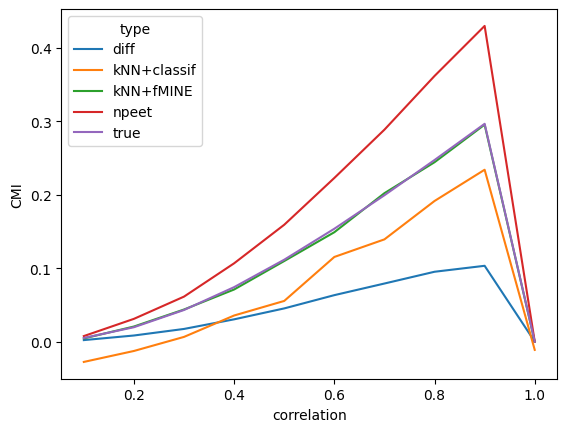

In [33]:
mean_val_df = df.groupby(["type", "cor"])["val"].mean().reset_index()
mean_val_df = mean_val_df[~mean_val_df["type"].str.startswith("cVAE")]

true_df = pd.DataFrame({"cor": np.linspace(.1, 1, 10), "val": [1/2*np.log(1+c**2) for c in np.linspace(.1, .9, 9)] + [0.]})
true_df["type"] = "true"
mean_val_df = pd.concat([mean_val_df, true_df], axis=0)
sns.lineplot(mean_val_df, x="cor", y="val", hue="type")
plt.xlabel("correlation")
plt.ylabel("CMI")

In [35]:
mean_val_df.shape

(50, 3)

In [41]:
squeezed = df.groupby(["type", "cor"])["val"].mean().reset_index()
extra = pd.DataFrame({"cor": np.linspace(.1, 1, 10), "val": [1/2*np.log(1+c**2) for c in np.linspace(.1, .9, 9)] + [0.], "type": "true"})
mean_val_df = pd.concat([squeezed, extra], axis=0).reset_index(drop=True)

<Axes: xlabel='cor', ylabel='val'>

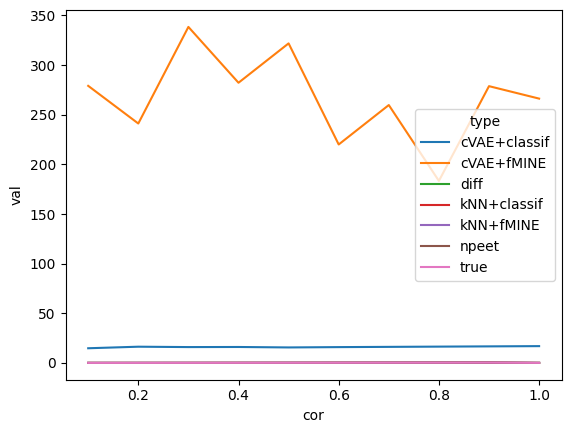

In [43]:
sns.lineplot(mean_val_df, x="cor", y="val", hue="type")

In [50]:
x, y, z = generate_mc(.5, 100000)
v2_knn, vp_knn = sample_q_knn(x, y, z)
v2_vae, vp_vae = sample_cvae(x, y, z)
y_t_knn = v2_knn[:, 1]
y_g_knn = vp_knn[:, 1]
y_t_vae = v2_vae[:, 1]
y_g_vae = vp_vae[:, 1]


<Axes: ylabel='Count'>

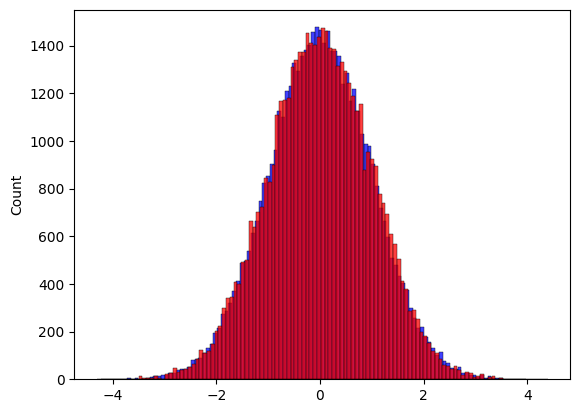

In [52]:
sns.histplot(y_t_knn, color="blue")
sns.histplot(y_g_knn, color="red")

<Axes: ylabel='Count'>

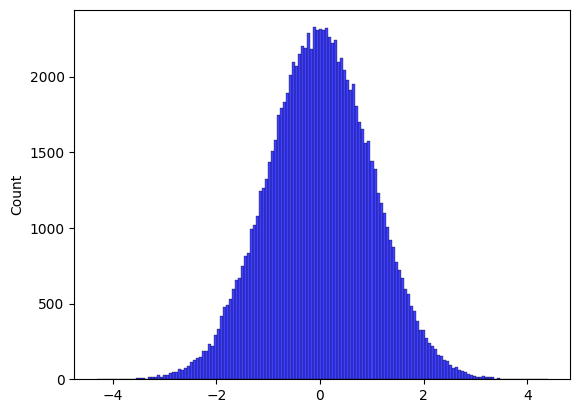

In [57]:
sns.histplot(y_t_vae, color="blue")


<Axes: ylabel='Count'>

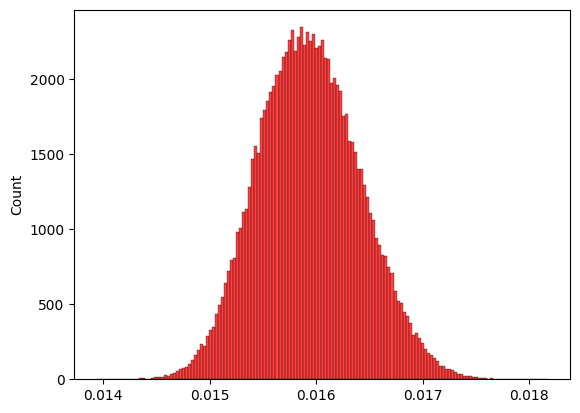

In [58]:
sns.histplot(y_g_vae, color="red")

In [12]:
sdf.groupby(["type", "col"])["val"].mean().sort_values(ascending=False)

type         col
kNN+fMINE    9      0.384451
             8      0.377661
             7      0.326276
             6      0.307771
             5      0.280892
             4      0.268133
             3      0.264206
             1      0.252078
             16     0.246735
             15     0.242823
             10     0.235356
             11     0.233350
             0      0.229106
             18     0.228982
kNN+classif  9      0.009505
kNN+fMINE    13     0.000005
             17    -0.000044
             19    -0.000096
             12    -0.000113
             2     -0.000188
             14    -0.000218
kNN+classif  8     -0.014737
             7     -0.038523
             6     -0.071251
             5     -0.101218
             4     -0.103045
             3     -0.118278
             2     -0.129126
             14    -0.130599
             16    -0.134024
             1     -0.134148
             11    -0.136608
             17    -0.138659
             12    -0.1390

In [14]:
from scipy.io import arff

data = arff.loadarff("dataset")
dataset = pd.DataFrame(data[0])
dataset
y = dataset["AverageTotalPayments"].values
x = dataset.drop("AverageTotalPayments", axis=1).values
res = []
for j in range(3):
    x = features[:, j]
    z = np.delete(features, j, axis=1)
    v2, vp = sample_q_knn(x, y, z)
    print("knn+MINE")
    res.append({
        "type": "kNN+fMINE",
        "val": divergence_based_cmi(v2, vp, 512, z.shape[1]).item(),
        "it": i,
        "col": j
    })
    print("knn+classif")
    res.append({
        "type": "kNN+classif",
        "val": classif_based_cmi(v2, vp),
        "it": i,
        "col": j
    })


knn+MINE
knn+classif
model acc: 0.409969696969697
knn+MINE
knn+classif
model acc: 0.41015151515151516
knn+MINE
knn+classif
model acc: 0.4216060606060606


In [16]:
rdf = pd.DataFrame(res)
rdf.groupby(["type", "col"])["val"].mean()

type         col
kNN+classif  0     -0.247715
             1     -0.248720
             2     -0.234156
kNN+fMINE    0     -0.000019
             1      0.000179
             2      0.000035
Name: val, dtype: float64